In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import rasterio
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import math
# import gdal
# from google.colab import drive
# drive.mount('/content/drive')
# base ='/content/drive/My Drive/'

In [6]:
os.getcwd()
os.chdir('/home/shoyo/Desktop')

In [24]:
# Set seed
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

In [8]:
csv_path = '/SOClandsat.csv'
df = pd.read_csv(os.getcwd() + csv_path)
df = df[0:19248]
df

,predsoc,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,ST_B10,EVI,vegstructure,Year.img,Month.img
0,6.84225,0.046084,0.083896,0.101895,0.278734,0.315350,0.210383,312.121586,0.279200,2,2020,1.5
1,6.84225,0.037091,0.079262,0.089864,0.287052,0.296664,0.183776,308.156683,0.332207,2,2020,5.5
2,6.84225,0.033324,0.071549,0.076073,0.271144,0.267087,0.171539,304.689102,0.325882,2,2020,8.0
3,6.84225,0.039663,0.074780,0.088063,0.274045,0.290077,0.189592,307.681579,0.308951,2,2020,11.0
4,6.84225,0.057372,0.102610,0.149814,0.264585,0.361550,0.269796,318.875594,0.171327,2,2021,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19243,13.22570,0.038246,0.068909,0.071714,0.278926,0.246902,0.138607,306.596357,0.364164,2,2020,8.0
19244,13.22570,0.033640,0.075990,0.055310,0.405151,0.213105,0.106213,298.823780,0.590169,2,2020,11.0
19245,13.22570,0.031907,0.063175,0.053962,0.302233,0.200565,0.103847,303.371455,0.331508,2,2021,2.0
19246,13.22570,0.029611,0.064632,0.047170,0.360698,0.185413,0.089066,305.150535,0.548532,2,2021,5.5


In [12]:
n = len(df)
# train_df = df[0:int(n*0.8)]
# val_df = df[int(n*0.8):int(n*0.9)]
# test_df = df[int(n*0.9):]
train_df = df[0:15400]
val_df = df[15400:(15400+1920)]
test_df = df[(15400+1920):]

scaler = StandardScaler()
Xtrain = scaler.fit_transform(train_df.iloc[:,1:])
Xtrain = Xtrain.reshape((  int(len(Xtrain)/8), 8, 11))
Ytrain = train_df.iloc[:,0][::8]
Ytrain = Ytrain.values.reshape((len(Ytrain),1))

Xval = scaler.fit_transform(val_df.iloc[:,1:])
Xval = Xval.reshape((  int(len(Xval)/8),8,11  ))
Yval = val_df.iloc[:,0][::8]
Yval = Yval.values.reshape((len(Yval),1))

Xtest = scaler.fit_transform(test_df.iloc[:,1:])
Xtest = Xtest.reshape(( int(len(Xtest)/8),8,11))
Ytest = test_df.iloc[:,0][::8]
Ytest = Ytest.values.reshape((len(Ytest),1))

num_features = df.shape[1]

# train_mean = train_df.mean()
# train_std = train_df.std()
# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

In [13]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
predsoc,15400.0,9.209159,10.844594,1.161600,4.074100,6.550300,10.545550,119.511800
SR_B2,15400.0,0.061227,0.027543,-0.065855,0.041873,0.055688,0.074629,0.499903
SR_B3,15400.0,0.102757,0.034950,0.021952,0.077420,0.094442,0.120612,0.504742
SR_B4,15400.0,0.132227,0.056853,0.010403,0.088155,0.125243,0.169627,0.531170
SR_B5,15400.0,0.268759,0.050784,0.062488,0.236996,0.267211,0.299771,0.637595
SR_B6,15400.0,0.290878,0.078197,0.029570,0.231942,0.289768,0.345353,0.586280
SR_B7,15400.0,0.215116,0.075860,0.017745,0.158645,0.213029,0.269250,0.502818
ST_B10,15400.0,314.895331,7.052041,286.395859,309.853730,315.661801,320.041139,334.755715
EVI,15400.0,0.218657,0.113282,0.035739,0.131369,0.185300,0.289010,0.764912
vegstructure,15400.0,4.827273,3.053121,1.000000,2.000000,4.000000,7.000000,10.000000


In [17]:
batch_size = 1280
units = 32
units_dense = 1  # labels are of one dimension
lr = 0.001
epochs = 1000

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units, input_shape=(8, 11), dropout=0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units_dense, activation='linear')])

2023-04-27 09:16:08.724003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 09:16:08.726177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 09:16:08.727534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [18]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                     tf.keras.metrics.RootMeanSquaredError()
                    ])

model.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_data=(Xval, Yval))

Epoch 1/1000


2023-04-27 09:16:15.736046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 09:16:15.737762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 09:16:15.739913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/2 [==============>...............] - ETA: 2s - loss: 177.3536 - mean_absolute_error: 8.9999 - root_mean_squared_error: 13.3174

2023-04-27 09:16:17.894825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 09:16:17.897312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 09:16:17.898851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 3s 580ms/step - loss: 194.4560 - mean_absolute_error: 9.2088 - root_mean_squared_error: 13.9447 - val_loss: 186.8589 - val_mean_absolute_error: 12.5958 - val_root_mean_squared_error: 13.6696
Epoch 2/1000
2/2 [==============================] - 0s 59ms/step - loss: 192.7386 - mean_absolute_error: 9.1952 - root_mean_squared_error: 13.8830 - val_loss: 185.6942 - val_mean_absolute_error: 12.5613 - val_root_mean_squared_error: 13.6270
Epoch 3/1000
2/2 [==============================] - 0s 58ms/step - loss: 190.6213 - mean_absolute_error: 9.1842 - root_mean_squared_error: 13.8066 - val_loss: 184.5518 - val_mean_absolute_error: 12.5270 - val_root_mean_squared_error: 13.5850
Epoch 4/1000
2/2 [==============================] - 0s 58ms/step - loss: 188.3777 - mean_absolute_error: 9.1742 - root_mean_squared_error: 13.7251 - val_loss: 183.4238 - val_mean_absolute_error: 12.4926 - val_root_mean_squared_error: 13.5434
Epoch 5/1000
2/2 [==========================

In [19]:
Ypred = model.predict(Xtest)

2023-04-27 09:17:47.923648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-27 09:17:47.925395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 09:17:47.926602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 0s 3ms/step


In [20]:
mse = mean_squared_error(Ypred, Ytest)
print("RMSE", math.sqrt(mse))
mae = mean_absolute_error(Ypred, Ytest)
print("MAE", mae)
R_square = r2_score(Ypred, Ytest) 
print('Coefficient of Determination', R_square) 

RMSE 4.740230088542999
MAE 3.39324819325174
Coefficient of Determination -1.908482019901554


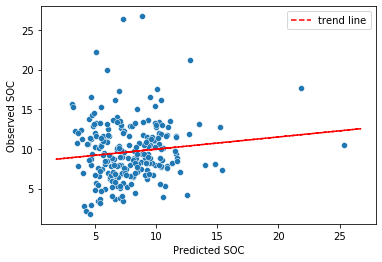

In [21]:
scatterplot=sns.scatterplot(x=np.squeeze(Ypred), y=np.squeeze(Ytest))
z = np.polyfit(np.squeeze(Ypred), np.squeeze(Ytest), 1)  #Least squares polynomial fit.
p = np.poly1d(z)                           #A one-dimensional polynomial class.
scatterplot.plot(np.squeeze(Ytest), p(np.squeeze(Ytest)), "r--", label='trend line')
plt.legend()
plt.xlabel("Predicted SOC")
plt.ylabel("Observed SOC")
plt.show()